In [ ]:
! pip install -q tensorflow==2.4.1 tensorflow-quantum

     |████████████████████████████████| 394.3 MB 12 kB/s 
     |████████████████████████████████| 7.8 MB 15.3 MB/s 
     |████████████████████████████████| 2.9 MB 17.0 MB/s 
     |████████████████████████████████| 3.8 MB 50.3 MB/s 
     |████████████████████████████████| 462 kB 54.1 MB/s 
     |████████████████████████████████| 90 kB 9.7 MB/s 
     |████████████████████████████████| 100 kB 10.2 MB/s 
     |████████████████████████████████| 1.3 MB 34.0 MB/s 
     |████████████████████████████████| 5.6 MB 33.8 MB/s 
     |████████████████████████████████| 90 kB 8.7 MB/s 
     |████████████████████████████████| 1.5 MB 38.0 MB/s 
     |████████████████████████████████| 380 kB 61.6 MB/s 
     |████████████████████████████████| 93 kB 1.3 MB/s 
     |████████████████████████████████| 93 kB 1.2 MB/s 
     |████████████████████████████████| 93 kB 1.3 MB/s 
     |████████████████████████████████| 93 kB 1.4 MB/s 
     |████████████████████████████████| 93 kB 1.1 MB/s 
     |██████████████████████

In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq


import cirq
import sympy
import numpy as np
import seaborn as sns
import collections
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler



# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
from statsmodels.tsa.api import ExponentialSmoothing

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
df = pd.read_csv("numerical_df_corrected.csv", index_col="Date")

In [ ]:
split_fraction = 0.8
train_split = int(split_fraction * int(df.shape[0]))

step = 1

past = 3
future = 1
learning_rate = 0.001
batch_size = 1
epochs = 100


def normalize(data, train_split):
    # data_mean = data[:train_split].mean(axis=0)
    # data_std = data[:train_split].std(axis=0)
    # return (data - data_mean) / data_std

    x = data.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled)

    return df.values

def smooth(dataset):
  for column in dataset.columns:
    data = dataset[column]
    exp = ExponentialSmoothing(data)
    exp_model = exp.fit(smoothing_level=0.5)
    result = exp_model.fittedvalues
    dataset[column] = result
    return dataset

In [ ]:
date_time_key = "Date"
print(
    "The selected parameters are:",
    ", ".join([df.columns[i] for i in [0, 1, 2, 3, 4, 5]]),
)
cols = [df.columns[i] for i in [0, 1, 2, 3, 4, 5]]
selected_features = [df.columns[i] for i in [0, 1, 2, 3, 4, 5]]
features = df[selected_features]
features.set_index(df.index, inplace=True)
#print(features.head())

features = smooth(features)
#print(features.head())

#features = normalize(features, train_split)
features = pd.DataFrame(features.values)







The selected parameters are: PS_Q_DAY, TPS_Q1_DAY, TWAS_DAF_QIN_DAY, DIGESTED_SLUDGE_QOUT_DAY, BIOGAS_PRODUCTION_Q_DAY, DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEK


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [ ]:
x = features[[0,1,2,3,5]]
y = features[[4]]

x = MinMaxScaler().fit_transform(x)
y = (y - np.min(y)) / (np.max(y) - np.min(y))



# Quantum NN
def convert_data(data, qubits, test=False):
    cs = []
    for i in data:
        cir = cirq.Circuit()
        for j in range(len(qubits)):
            cir += cirq.rx(i[j] * np.pi).on(qubits[j])
            cir += cirq.ry(i[j] * np.pi).on(qubits[j])
        cs.append(cir)
    if test:
        return tfq.convert_to_tensor([cs])
    return tfq.convert_to_tensor(cs)

def encode(data, labels, qubits):
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=.2, random_state=43)
    return convert_data(X_train, qubits), convert_data(X_test, qubits), y_train, y_test

def layer(circuit, qubits, params):
    for i in range(len(qubits)):
        if i + 1 < len(qubits):
            circuit += cirq.CNOT(qubits[i], qubits[i + 1])
        circuit += cirq.ry(params[i * 2]).on(qubits[i])
        circuit += cirq.rz(params[i * 2 + 1]).on(qubits[i])
    circuit += cirq.CNOT(qubits[-1], qubits[0])
    return circuit

def model_circuit(qubits, depth):
    cir = cirq.Circuit()
    num_params = depth * 2 * len(qubits)
    params = sympy.symbols("q0:%d"%num_params)
    for i in range(depth):
        cir = layer(cir, qubits, params[i * 2 * len(qubits):i * 2 * len(qubits) + 2 * len(qubits)])
    return cir

qs = [cirq.GridQubit(0, i) for i in range(5)]
d = 3
X_train, X_test, y_train, y_test = encode(x, y, qs)
c = model_circuit(qs, d)
print(c)

readout_operators = [cirq.Z(qs[0])]
inputs = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
#layer1 = tfq.layers.PQC(c, readout_operators, repetitions=32, differentiator=tfq.differentiators.ParameterShift())(inputs)
layer1 = tfq.layers.PQC(c, readout_operators, differentiator=tfq.differentiators.Adjoint())(inputs)
vqc = tf.keras.models.Model(inputs=inputs, outputs=layer1)
vqc.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=3e-3))
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

v_history = vqc.fit(X_train, y_train, epochs=100, batch_size=1, validation_data=(X_test, y_test), callbacks=[callback])


plt.plot(v_history.history['loss'], label='Quantum Training Loss')
plt.plot(v_history.history['val_loss'], label='Quantum Validation Loss')
plt.plot(c_history.history['loss'], label='Classical Training Loss')
plt.plot(c_history.history['val_loss'], label='Classical Validation Loss')
plt.legend()
plt.show()
plt.savefig("predictions")

Epoch 1/100
22/22 [==============================] - 1s 10ms/step - loss: 0.0687 - val_loss: 0.0224
Epoch 2/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0279 - val_loss: 0.0214
Epoch 3/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0263 - val_loss: 0.0214
Epoch 4/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0238 - val_loss: 0.0214
Epoch 5/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0257 - val_loss: 0.0218
Epoch 6/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0240 - val_loss: 0.0219
Epoch 7/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0247 - val_loss: 0.0218
Epoch 8/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0255 - val_loss: 0.0209
Epoch 9/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0272 - val_loss: 0.0255
Epoch 10/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0255 - val_loss: 0.0231
Epoch 11

KeyboardInterrupt: ignored

In [ ]:
train_data = x[0 : train_split - 1]

val_data = x[train_split:]

In [ ]:
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(6)]]
y_train = features.iloc[start:end][[4]]

sequence_length = int(past / step)


x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(6)]].values
y_val = features.iloc[label_start:][[4]]

AttributeError: ignored

In [ ]:
def convert_to_circuit(row):
    """Encode a vector with features in [1, 1000] using angle-encoding"""
    values = (np.ndarray.flatten(row).astype(np.float32) - 1) / 9999
    qubits = cirq.GridQubit.rect(1, len(values))
    circuit = cirq.Circuit(cirq.X(q) ** v for v,q in zip(values, qubits))
    return circuit

In [ ]:
x_train_circ = [convert_to_circuit(x) for x in x_train]
x_test_circ = [convert_to_circuit(x) for x in x_val]

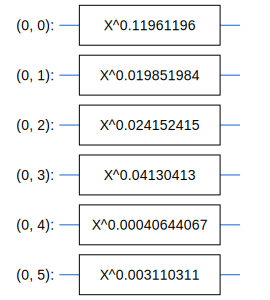

In [ ]:
SVGCircuit(x_train_circ[0])


In [ ]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

In [ ]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout

    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

In [ ]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()

    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))

    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [ ]:
model_circuit, model_readout = create_quantum_model()

In [ ]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

In [ ]:
y_train_hinge = 2.0*y_train-1.0
y_test_hinge = 2.0*y_val-1.0

In [ ]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [ ]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc (PQC)                    (None, 1)                 32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
EPOCHS = 1
BATCH_SIZE = 8

NUM_EXAMPLES = len(x_train_tfcirc)

In [ ]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]